# Clusterização para organização das entregas
O centro Frei Humberto sente falta de uma maneira automatizada de organizar a entrega dos pedidos. Aqui será apresentada uma forma de agrupar os pedidos por localização, o que facilita a separação dos pedidos por entregador.<p>
Há pedidos que são agendados para retirada na sede da feira, porém, como são poucos, vamos relevar tal informação neste momento. Entretanto, deve haver preocupação em retirá-los da clusterização caso esta solução seja implementada em produção. Outra preocupação que aqui será ignorada é a remoção manual de pedidos cujas coordenadas geográficas não foram descobertas automaticamente.
<p>
Selecionaremos amostra de pedidos já realizados para testar as soluções implementadas. Como foi possível verificar no notebook <b>2 - Análise e Exploração dos Dados.ipynb</b>, o ciclo de vendas e entregas ocorre de forma mensal. Selecionaremos, portanto, os pedidos do mês com maior volume de pedido para  nossos testes.

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

Primeiramente vamos verificar a quantidade de pedidos por mês. Trabalharemos com o mês com maior volume de vendas.

In [214]:
df =  pd.read_csv('arquivos/pedidos_wide_final.csv')
df['data_pedido'] = pd.to_datetime(df['data_pedido'])
df['data_pedido'] = df['data_pedido'].dt.to_period('M')
df['data_pedido'].value_counts()

2020-07    366
2020-08    322
2020-10    305
2020-09    293
2020-11    264
2020-12    262
2021-02    262
2021-01    212
2021-07    202
2021-05    195
2021-09    171
2021-06    164
2021-08    164
2021-10    138
2021-11     73
2022-02     61
2021-12     49
2022-01     24
Freq: M, Name: data_pedido, dtype: int64

Nossa massa será composta pelos pedidos de julho de 2020. Vamos separar esses pedidos e acrescentar a eles as coordenadas do CEP, que foram obtidas em **2.1 - Captura de coordenadas geográficas por CEP.ipynb**.

In [215]:
df = df[df['data_pedido'] == '2020-07'].filter(['id_pedido','cep_pedido'])

# Vamos ler as coordenadas de todos os CEPs presentes na massa de dados.
df_coords = pd.read_csv('arquivos/Coordenadas geográficas dos CEPs.csv')

# Definindo uma função que retorna as coordenadas geográficas de um CEP.
def ret_coord_geo(cep):
    if cep in list(df_coords['cep']):
        latitude = df_coords[df_coords['cep'] == cep]['lat'].values[0]
        longitude = df_coords[df_coords['cep'] == cep]['long'].values[0]
        return latitude,longitude
    else:
        return None,None
    
# Montando uma lista com as coordenadas geográficas de cada pedido.
lista_coords = [ret_coord_geo(cep) for cep in df['cep_pedido']]

# Acrescentando latitude e longitude ao DataFrame, removendo alguns poucos pedidos cujas coordenadas geográficas são
# desconhecidas.
df['lat'] = [pos[0] for pos in lista_coords]
df['long'] = [pos[1] for pos in lista_coords]
df.dropna(inplace=True)
df.head()

,id_pedido,cep_pedido,lat,long
0,54,60150060,-3.736327,-38.504833
1,56,60320105,-3.726792,-38.562826
2,59,60713480,-3.795657,-38.578317
3,60,60431075,-3.739664,-38.550117
4,64,60430660,-3.740088,-38.546496


Vamos visualizar os pedidos selecionados em um mapa.

In [216]:
mapa = folium.Map(location=[-3.77, -38.53],tiles='OpenStreetMap',zoom_start=12)
ped_coords = df[['id_pedido','lat','long']].values.tolist()

for id_p,lat,long in ped_coords:
    folium.CircleMarker([lat,long],popup=int(id_p),radius=2,color='blue').add_to(mapa)

folium.Marker([-3.7571739265915802,-38.51565613865088],popup='Sede do Centro Frei Humberto').add_to(mapa)
mapa

## DBSCAN + K-Means para separação de pedidos por entregador
Utilizaremos primeiramente DBSCAN para separar outliers que ficam muito distantes, cuja entrega deve ser realizada de maneira diferenciada, aplicando, então, K-Means para separar o restante dos pedidos em grupos. A separação se dará com K-Means porque definimos ele recebe um hiper parâmetro que determina a quantidade de clusters a serem criados.<p>
O X consistirá somente nos pontos de latitude e longitude, dado que eles que indicam o ponto de entrega. Os dados serão normalizados. Para maiores detalhes do funcionamento, da análise dos dados e da seleção de hiper parâmetros do DBSCAN, verificar o notebook **3 - Detecção de outliers com agrupamento DBSCAN.ipynb**, onde ele já foi previamente utilizado e explicado.

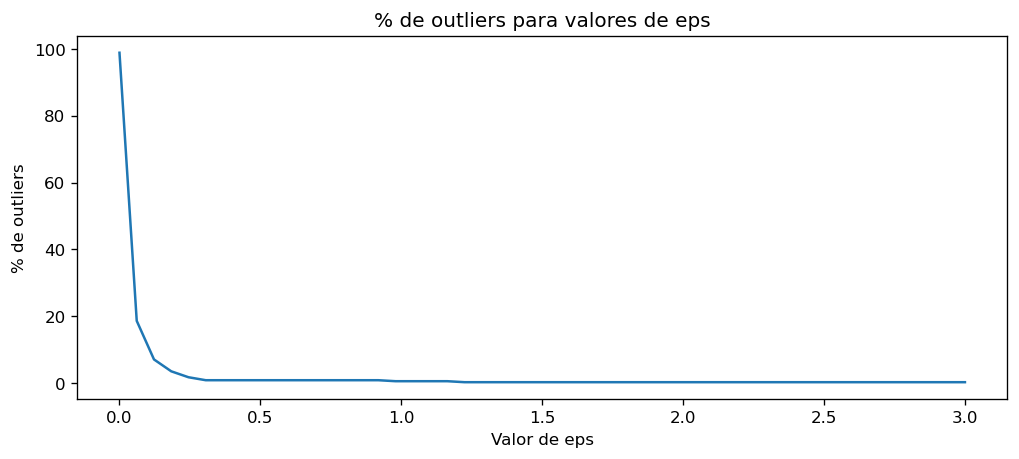

In [217]:
X = df[['lat','long']]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

percent_outliers = list()
ms = scaled_X.shape[1] * 2
lista_eps = np.linspace(0.001,3,50) # 50 valores que testaremos para eps

for eps in lista_eps:
    modelo_dbscan = DBSCAN(min_samples=ms,eps=eps)
    modelo_dbscan.fit(scaled_X)
    
    nr_outliers = np.sum(modelo_dbscan.labels_ == -1) # DBSCAN atribui label -1 aos outliers
    perc_outliers = 100 * nr_outliers / len(modelo_dbscan.labels_)
    percent_outliers.append(perc_outliers)
    
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps');

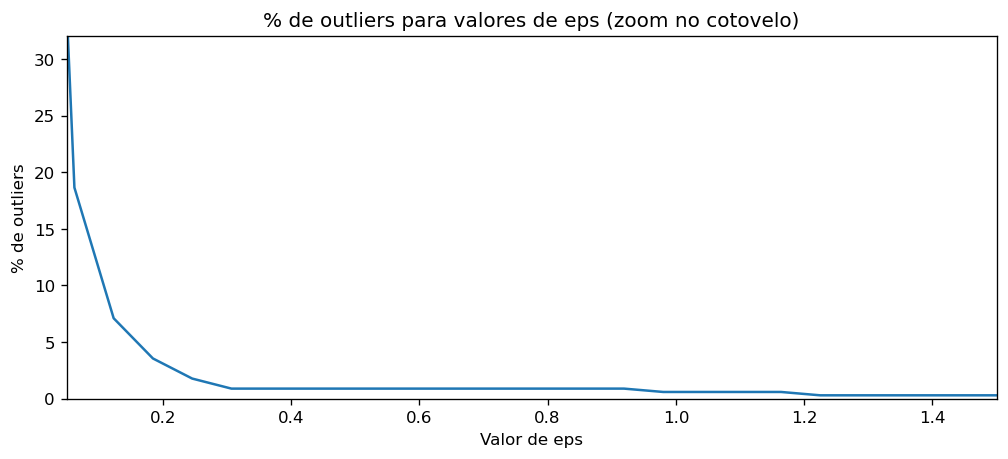

In [218]:
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps (zoom no cotovelo)')
plt.xlim(0.05,1.5)
plt.ylim(0,32);

Trabalharemos com 0.3 como valor de eps, que parece estar estimando uma boa quantidade de pontos muito afastados. Vejamos quantos endereços foram selecionados como outliers.

In [219]:
modelo_dbscan = DBSCAN(min_samples=ms,eps=0.3)
labels = modelo_dbscan.fit_predict(scaled_X)
df['label'] = labels
df['label'].value_counts()

 0    334
-1      4
Name: label, dtype: int64

Vamos visualizar estes outliers no mapa. Estão marcados com a cor vermelha.

In [220]:
mapa = folium.Map(location=[-8, -38.53],tiles='OpenStreetMap',zoom_start=6)
ped_coords = df[['id_pedido','lat','long','label']].values.tolist()

for id_p,lat,long,label in ped_coords:
    if label == -1:
        cor = 'red'
    else:
        cor = 'blue'

    folium.CircleMarker([lat,long],popup=int(id_p),color=cor,radius=2).add_to(mapa)

mapa

Vamos separar os outliers do resto dos pedidos para fazer a clusterização dos que não são outliers com K-Means.

In [221]:
df_outliers = df[df['label'] == -1].copy()
df = df[df['label'] != -1]

Vamos assumir que há 5 entregadores, o que resulta na necessidade de criação de 5 clusters. Inicialmente vamos simplesmente classificar os dados uma única vez com K-Means e verificar os resultados, lembrando que a escolha inicial dos centros dos clusters é aleatória, o que implica na geração de diferentes clusters a cada execução.

In [222]:
X = df[['lat','long']]
scaled_X = scaler.fit_transform(X)

modelo_kmeans = KMeans(n_clusters=5)
labels = modelo_kmeans.fit_predict(scaled_X)
df['label'] = labels

df['label'].value_counts()

0    131
4     97
2     39
1     36
3     31
Name: label, dtype: int64

Podemos ver que a quantidade de entregas por entregador não ficou muito equilibrada, mas é importante lembrar que não é somente esta a única variável que determina o tempo de trabalho de um entregador. A distância a ser percorrida entre os pontos também deve ser levada em consideração. Visualizemos a divisão no mapa para melhor compreender esta questão.

In [223]:
mapa = folium.Map(location=[-3.77, -38.53],tiles='OpenStreetMap',zoom_start=12)
ped_coords = df[['id_pedido','lat','long','label']].values.tolist()

cores = {0:'green',1:'red',2:'purple',3:'black',4:'darkblue'}

for id_p,lat,long,label in ped_coords:
    folium.CircleMarker([lat,long],popup=int(id_p),color=cores[label],radius=2).add_to(mapa)

folium.Marker([-3.7571739265915802,-38.51565613865088],popup='Sede do Centro Frei Humberto').add_to(mapa)
mapa

No geral, esta é uma boa divisão pois o tempo de trabalho de um entregador depende tanto das entregas a serem feitas quanto do tempo de deslocamento necessário para deslocar-se de um ponto a outro. Em poutras palavras, o pagamento pelos serviços de entrega leva em consideração tanto a quantidade de quilômetros rodados quanto a quantidade de entregas efetuadas.

## Itinerário
Após definirmos quais entregas cada entregador fará, naturalmente nos questionamos quanto ao itinerário a ser seguido por cada um deles para otimizar a rota ao longo das entregas. Esta solução está além do escopo deste trabalho mas, para não deixar esta questão passar completamente em branco, vamos nos utilizar de DBSCAN mais uma vez, desta vez num subgrupo de entregas de um entregador específico. A idéia é sugerir agrupamentos de entregas próximas entre si, que o entregador poderá utilizar para otimizar seu trabalho.<p>
Selecionaremos um dos clusters criado acima para fazer tal análise.

In [233]:
cluster_int = 0

df_ce = df[df['label'] == cluster_int].copy()
df_ce.head()

,id_pedido,cep_pedido,lat,long,label
0,54,60150060,-3.736327,-38.504833,0
7,68,60120001,-3.738091,-38.507750,0
11,76,60191335,-3.749958,-38.466640,0
12,81,60176125,-3.744077,-38.471243,0
15,87,60192072,-3.745170,-38.481485,0


Desta vez, ao invés de fazermos a seleção do valor de epsilon por meio de análise visual, selecionaremos o valor que torne a quantidade de outliers imediatamente inferior a 5% ou gere 14 grupos (incluindo grupo de outliers, caso existam). Testes demonstraram que o menor valor para min_samples é 2, a quantidade de dimensões em nosso X.

In [234]:
X = df_ce[['lat','long']]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

ms = scaled_X.shape[1]

# Descobrindo o valor de eps a ser usado
eps = 0.001

while True:
    modelo_dbscan = DBSCAN(min_samples=ms,eps=eps)
    subgrupos = modelo_dbscan.fit_predict(scaled_X)
    
    nr_outliers = np.sum(modelo_dbscan.labels_ == -1) # DBSCAN atribui label -1 aos outliers
    perc_outliers = 100 * nr_outliers / len(modelo_dbscan.labels_)
    
    if perc_outliers <= 5 or len(np.unique(subgrupos)) == 14:
        eps_final = eps
        break
    else:
        eps += 0.05
        
df_ce['subgrupo'] = subgrupos
df_ce.head()

,id_pedido,cep_pedido,lat,long,label,subgrupo
0,54,60150060,-3.736327,-38.504833,0,0
7,68,60120001,-3.738091,-38.507750,0,0
11,76,60191335,-3.749958,-38.466640,0,-1
12,81,60176125,-3.744077,-38.471243,0,1
15,87,60192072,-3.745170,-38.481485,0,2


Finalmente vamos validar os subgrupos criados em um mapa. **Importante:** outliers estarão em vermelho (subgrupo -1). Ficará a cargo do entregador decidir como é melhor inserí-los no itinerário.

In [235]:
mapa = folium.Map(location=[-3.77, -38.53],tiles='CartoDB positron',zoom_start=12)

cores = {-1:'red',0:'blue',1:'gray',2:'darkred',3:'orange',4:'green',5:'lightgreen',6:'darkblue',7:'lightblue',
         8:'purple',9:'pink',10:'cadetblue',11:'lightgray',12:'black'}

for lat,long,id_p,subg in df_ce[['lat','long','id_pedido','subgrupo']].values.tolist():
    folium.CircleMarker([lat,long],popup=int(id_p),color=cores[subg],radius=2).add_to(mapa)

folium.Marker([-3.7571739265915802,-38.51565613865088],popup='Sede do Centro Frei Humberto').add_to(mapa)
mapa

O entregador não receberia um mapa em mãos, mas sim uma listagem similar ao que podemos ver a seguir.

In [237]:
pd.set_option("display.max_rows", None)
df_ce.sort_values('subgrupo')

,id_pedido,cep_pedido,lat,long,label,subgrupo
58,226,60181255,-3.731519,-38.476501,0,-1
257,760,60810005,-3.759465,-38.484779,0,-1
11,76,60191335,-3.749958,-38.466640,0,-1
228,675,60175175,-3.739424,-38.478224,0,-1
46,178,60810165,-3.763338,-38.484101,0,-1
173,538,60190320,-3.750695,-38.473748,0,-1
136,443,60140110,-3.737880,-38.510039,0,0
221,666,60115281,-3.731868,-38.506900,0,0
209,638,60110300,-3.736155,-38.516418,0,0
198,616,60115221,-3.732224,-38.508213,0,0


In [238]:
pd.set_option("display.max_rows", 10)